# Kaggle Bike Sharing Demand Prediction

#### Peter Grabowski, Xiao Wu, Utthaman Thirunavukkarasu

In [150]:
%matplotlib inline

import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import time
from datetime import datetime
import calendar

# Neural Network libraries
import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
print (theano.config.device) # We're using CPUs (for now)
print (theano.config.floatX) # Should be 64 bit for CPUs

# Decision Tree libraries
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

np.random.seed(0)

from IPython.display import display, clear_output 

import matplotlib.pyplot as plt
import seaborn as sns #need to install seaborn "conda install seaborn"
%matplotlib inline

cpu
float64


## Read Data

In [115]:
# Import bikeshare data
train_csv = "train.csv" 
train_types = (datetime, int, bool, bool, int, float, float, int, float, int, int, int)
train = np.genfromtxt(train_csv,delimiter=',',dtype=train_types, names=True)
train_pd = pd.read_csv(train_csv)

test_csv = "test.csv" 
test_types = (datetime, int, bool, bool, int, float, float, int, float)
test = np.genfromtxt(test_csv,delimiter=',',dtype=test_types,names=True)
test_pd = pd.read_csv(test_csv)

In [116]:
# look at dataframe
print(train_pd[:5])

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  


## Feature Engineering

In [119]:
# feature engineering

day_map = {0: 'Monday', 
           1: 'Tuesday', 
           2 : 'Wednesday', 
           3 : 'Thursday', 
           4 : 'Friday', 
           5 : "Saturday", 
           6 : "Sunday"}

month_map = {1: "January",
             2 : "February",
             3 : "March",
             4 : "April",
             5 : "May",
             6 : "June",
             7 : "July",
             8 : "August",
             9 : "September",
             10 : "October",
             11 : "November",
             12 : "December"}

season_map = {1: "Spring", 
              2 : "Summer", 
              3 : "Fall", 
              4 :"Winter" }

weather_map = {1: " Clear + Few clouds + Partly cloudy + Partly cloudy",
               2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", 
               3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", 
               4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " }

def getDayNameFromTimestamp(x):
    datestr =  str(x).split()[0]
    weekday_num = datetime.strptime(datestr,"%Y-%m-%d").weekday()
    return weekday_num

def getDateFromTimestamp(x):
    return str(x).split()[0]
    
def getHourFromTimestamp(x):
    return int(str(x).split()[1].split(":")[0])

def getWeekdayNameFromTimestamp(x):
    datestr =  str(x).split()[0]
    day_num = datetime.strptime(datestr,"%Y-%m-%d").weekday()
#     return day_map[day_num]
    return day_num

def getMonthNameFromTimestamp(x):
    datestr =  str(x).split()[0]
    month_num = datetime.strptime(datestr,"%Y-%m-%d").month
#     return month_map[month_num]
    return month_num
    
train_pd['day'] = train_pd['datetime'].apply(lambda x: getDayNameFromTimestamp(x))
train_pd['hour'] = train_pd['datetime'].apply(lambda x: getHourFromTimestamp(x))
train_pd["weekday"] = train_pd['datetime'].apply(lambda x : getDayNameFromTimestamp(x))
train_pd["month"] =  train_pd['datetime'].apply(lambda x : getMonthNameFromTimestamp(x))
train_pd["season_str"] = train_pd['season'].map(season_map)
train_pd["weather_str"] = train_pd['weather'].map(weather_map)

test_pd['day'] = test_pd['datetime'].apply(lambda x: getDayNameFromTimestamp(x))
test_pd['hour'] = test_pd['datetime'].apply(lambda x: getHourFromTimestamp(x))
test_pd["weekday"] = test_pd['datetime'].apply(lambda x : getDayNameFromTimestamp(x))
test_pd["month"] =  test_pd['datetime'].apply(lambda x : getMonthNameFromTimestamp(x))
test_pd["season_str"] = test_pd['season'].map(season_map)
test_pd["weather_str"] = test_pd['weather'].map(weather_map)

In [112]:
# more feature engineering -- make columns be categorical
categoricalColumns = ["hour",
                      "weekday",
                      "month",
                      "season", 
                      "season_str",
                      "weather", 
                      "weather_str",
                      "holiday",
                      "workingday"]

for column in categoricalColumns:
    train_pd[column] = train_pd[column].astype("category")

In [120]:
print(train_pd[:10])

              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
5  2011-01-01 05:00:00       1        0           0        2   9.84  12.880   
6  2011-01-01 06:00:00       1        0           0        1   9.02  13.635   
7  2011-01-01 07:00:00       1        0           0        1   8.20  12.880   
8  2011-01-01 08:00:00       1        0           0        1   9.84  14.395   
9  2011-01-01 09:00:00       1        0           0        1  13.12  17.425   

   humidity  windspeed  casual  registered  count  day  hour  weekday  month  \
0        81     0.0000       3          13     16 

## Simple Data Visualization

### Dependent Variables

By looking at the count distribution, we realized it is highly skewed, which may create some problem. We are going to use the logarithm values in order to avoid it. 

/Users/kx/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


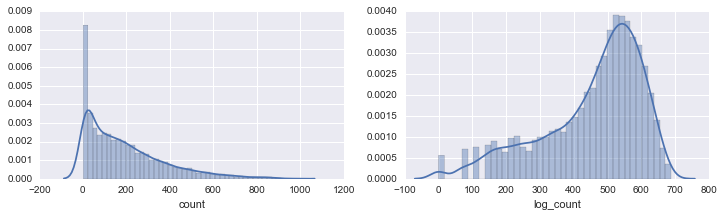

In [199]:
train_pd['log_count'] = (np.log(train_pd['count']) * 100).astype("int") #time 100 and transform to integers for label prediction
train_pd['log_casual'] = (np.log(train_pd['casual'] + 1) * 100).astype("int") #add 1 before transforming to log to avoid error
train_pd['log_registered'] = (np.log(train_pd['registered'] + 1) * 100).astype("int") #add 1 before transforming to log to avoid error

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
sns.distplot(train_pd['count'], ax=axs[0])
sns.distplot(train_pd['log_count'], ax=axs[1])

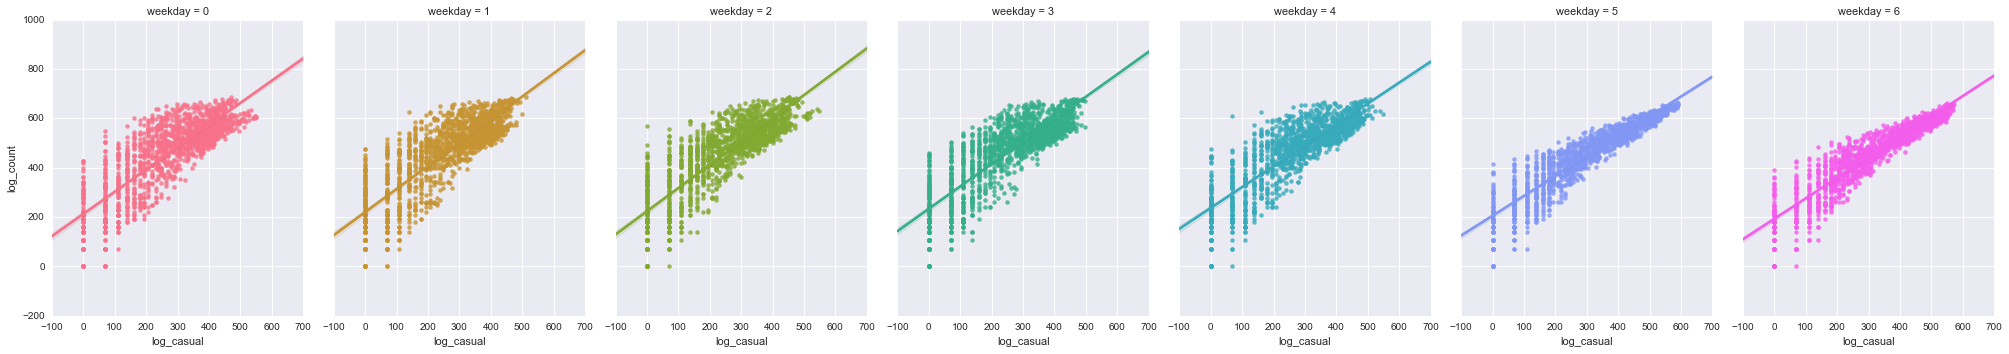

In [7]:
sns.lmplot(x="log_casual", y="log_count", hue="weekday", col="weekday", data=train_pd, aspect=.8, x_jitter=.1)

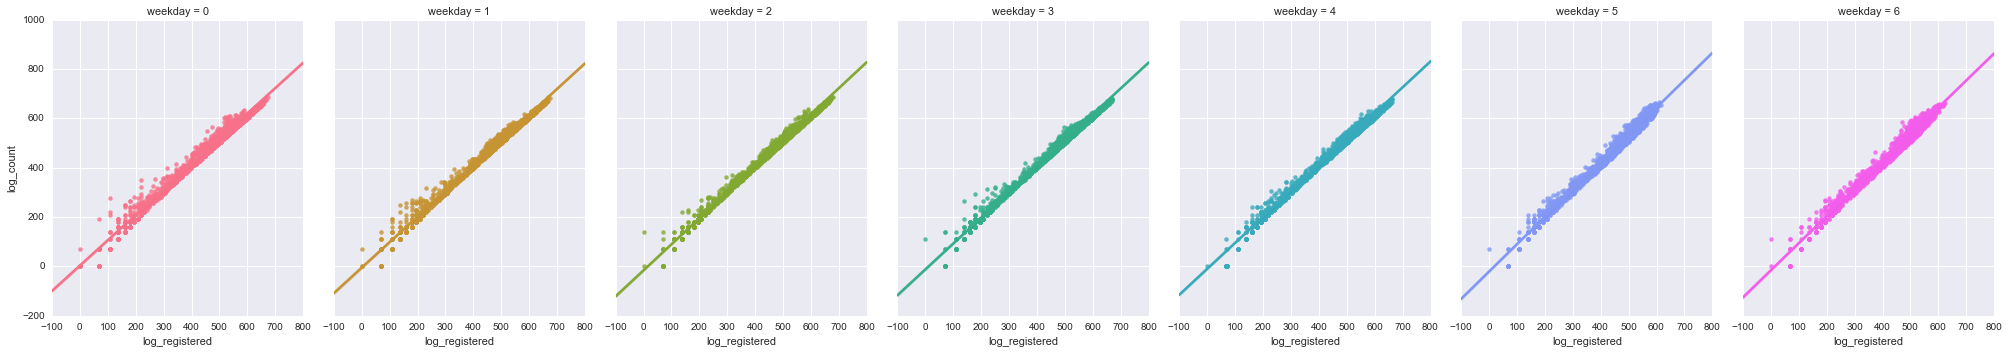

In [8]:
sns.lmplot(x="log_registered", y="log_count", hue="weekday", col="weekday", data=train_pd, aspect=.8, x_jitter=.1)

The count for registered and casual are showing very different patterns. Therefore, we are going to make separate predictions for each.

### Independent Variables

Check weather and season.

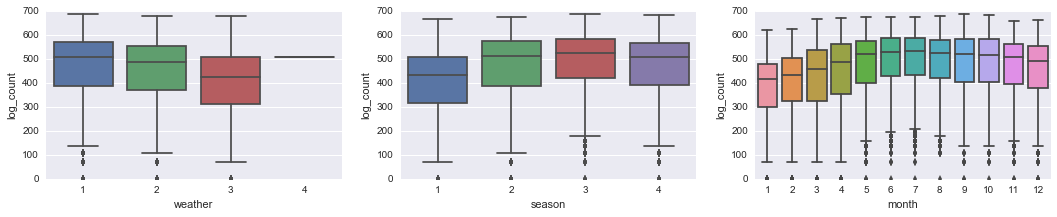

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,3))
sns.boxplot(x="weather", y="log_count", data=train_pd, ax=axs[0])
sns.boxplot(x="season", y="log_count", data=train_pd, ax=axs[1])
sns.boxplot(x="month", y="log_count", data=train_pd, ax=axs[2])

Since season and month would be highly correlated, we will just use one of them.

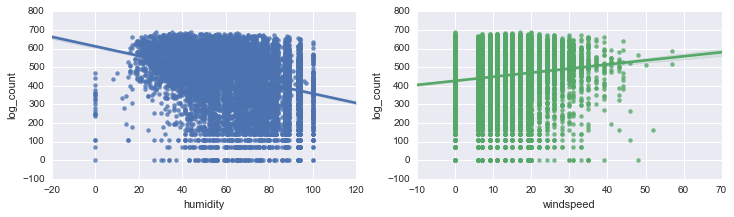

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
sns.regplot(x="humidity", y="log_count", data=train_pd, ax=axs[0])
sns.regplot(x="windspeed", y="log_count", data=train_pd, ax=axs[1])

Check holiday and weekday.

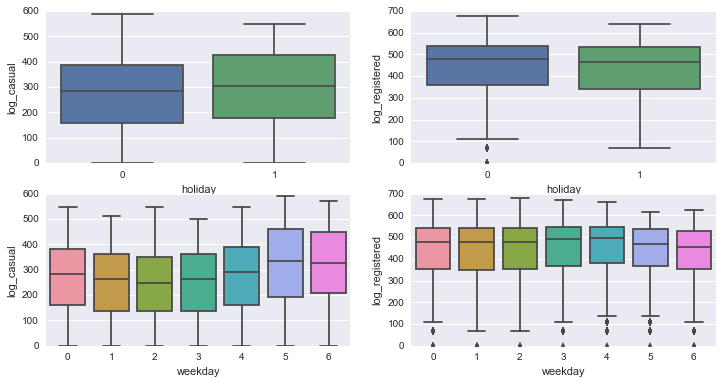

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
sns.boxplot(x="holiday", y="log_casual", data=train_pd, ax=axs[0,0])
sns.boxplot(x="holiday", y="log_registered", data=train_pd, ax=axs[0,1])
sns.boxplot(x="weekday", y="log_casual", data=train_pd, ax=axs[1,0])
sns.boxplot(x="weekday", y="log_registered", data=train_pd, ax=axs[1,1])

There's not much difference between holiday and non-holiday, thus we are not going to use this variable.

Check hour data.

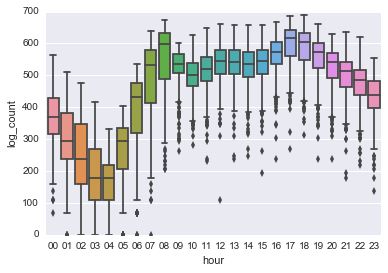

In [12]:
sns.boxplot(x="hour", y="log_count", data=train_pd)

Test: add an "hour_bin" variable that assigns hour data into 4 bins.

In [13]:
hour_avg = train_pd.groupby('hour', as_index=False)['log_count'].mean()
sorted = hour_avg.sort(['log_count', 'hour'], ascending=[0, 1])
print(sorted)

   hour   log_count
17   17  599.234649
18   18  588.967105
16   16  560.767544
19   19  558.164474
8    08  556.307692
13   13  536.673246
12   12  536.355263
15   15  534.839912
14   14  529.335526
9    09  527.356044
20   20  525.796053
11   11  515.050549
10   10  498.551648
21   21  498.309211
7    07  489.558242
22   22  471.975877
23   23  429.254386
6    06  388.929670
0    00  369.753846
1    01  302.348018
5    05  267.429204
2    02  247.415179
3    03  193.471132
4    04  160.427602


/Users/kx/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [200]:
def convert_hour(hour):
    if hour in  ['17','18','16','19','08','13']:
        return 0
    elif hour in  ['12','15','14','09','20','11']:
        return 1
    elif hour in  ['10','21','07','22','23','06']:
        return 2
    else:
        return 3
train_pd["hour_bin"] = train_pd['hour'].apply(lambda hour : convert_hour(hour))
test_pd["hour_bin"] = test_pd['hour'].apply(lambda hour : convert_hour(hour))

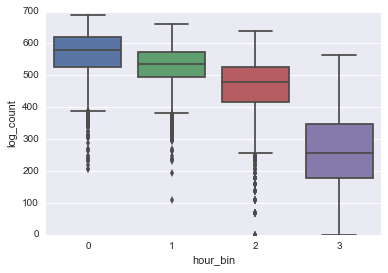

In [15]:
sns.boxplot(x="hour_bin", y="log_count", data=train_pd)

## Define Train, Dev, and Test Datasets

In [201]:
# Separate out a development set
divide = int(len(train_pd)*0.8)
train_set = train_pd[:divide]
dev_set = train_pd[divide:len(train_pd)]

In [224]:
data = train_pd[['hour', 'season', 'weekday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']]
label = train_pd[['log_casual', 'log_registered', 'log_count', 'count']]

In [225]:
# Separate out a development set
divide = int(len(train_pd)*0.8)
train_data = data[:divide]
train_label = label[:divide]
dev_data = data[divide:len(train_pd)]
dev_label = label[divide:len(train_pd)]

In [217]:
numFeatures = len(train_data.columns)
numTrainExamples = len(train_data)
numDevExamples = len(dev_data)
numTestExamples = len(test_pd)

print ('Features = %d' %(numFeatures))
print ('Train set = %d' %(numTrainExamples))
print ('Dev set = %d' %(numDevExamples))
print ('Test set = %d' %(numTestExamples))

Features = 8
Train set = 8708
Dev set = 2178
Test set = 6493


In [218]:
print(train_data[:5])
print(train_label[:5])

   hour_bin  season  weekday  weather  temp   atemp  humidity  windspeed
0         3       1        5        1  9.84  14.395        81        0.0
1         3       1        5        1  9.02  13.635        80        0.0
2         3       1        5        1  9.02  13.635        80        0.0
3         3       1        5        1  9.84  14.395        75        0.0
4         3       1        5        1  9.84  14.395        75        0.0
   log_casual  log_registered  log_count  count
0         138             263        277     16
1         219             349        368     40
2         179             333        346     32
3         138             239        256     13
4           0              69          0      1


## Compare Different Models

Linear Regression was used to do baseline prediction. With the dataset, we think neural network or random forest regressor may do a better prediction, something like "if its not too hot, and not too windy, and not too humid, and it's a week day with commute, predict a high number of riders"

Since the predict labels are continuous instead of categorical, we used mean squared error to compare the models and tune parameters.

### Baseline Model

In [235]:
lm0 = LinearRegression()
lm1 = LinearRegression()
train_temps = train_data['temp'].reshape(-1, 1)
lm0.fit(train_temps, train_label['log_casual'])
lm1.fit(train_temps, train_label['log_registered'])

dev_temps = dev_data['temp'].reshape(-1, 1)
lm_preds = (np.exp(lm0.predict(dev_temps)/100)-1 + np.exp(lm1.predict(dev_temps)/100)-1).astype("int")

print(mean_squared_error(lm_preds, dev_label['log_count']))

173665.348944


### Neural Network with Theano

In [236]:
def binarizeY(data):
    binarized_data = np.zeros((len(data),train_pd['log_count'].max()+1), dtype=np.int)
    for j in range(0,len(data)):
        i = data[j:j+1]
        binarized_data[j,i]=1
    return binarized_data

train_label_b = binarizeY(train_label['log_count'])
dev_label_b = binarizeY(dev_label['log_count'])
numClasses = len(train_label_b[1])

print ('Classes = %d' %(numClasses))

/Users/kx/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Classes = 689


In [237]:
## (1) Parameters
w = theano.shared(np.asarray((np.random.randn(*(numFeatures, numClasses))*.01)))

## (2) Model
X = T.matrix()
Y = T.matrix()
def model(X, w):
    return T.nnet.softmax(T.dot(X, w))
y_hat = model(X, w)

## (3) Cost
cost = T.mean(T.nnet.categorical_crossentropy(y_hat, Y))

## (4) Objective
alpha = 0.01
gradient = T.grad(cost=cost, wrt=w)
update = [[w, w - gradient * alpha]] 
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True) 
y_pred = T.argmax(y_hat, axis=1) 
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

miniBatchSize = 5
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(train_data), miniBatchSize), range(miniBatchSize, len(train_data), miniBatchSize)):
            cost = train(train_data[start:end], train_label_b[start:end])
        trainTime =  trainTime + (time.time() - start_time)
        clear_output(wait=True)
        print (mean_squared_error(predict(dev_data), np.argmax(dev_label_b, axis=1)))
#     print ('train time = %.2f' %(trainTime))
    
gradientDescentStochastic(50)

preds = predict(dev_data)
start_time = time.time()

15993.0142332


## Random Forest

In [ ]:
np.random.seed(1)

# a single iteration of tree bagging

bootstrap_sample_index = np.random.choice(range(len(train_data)), size=len(train_data), replace=True)
bs_data = train_data.iloc[bootstrap_sample_index]
bs_labels0 = train_label['log_casual'][bootstrap_sample_index]
bs_labels1 = train_label['log_registered'][bootstrap_sample_index]
    
# decision tree
bs_tree0 = DecisionTreeRegressor(splitter="best")
bs_tree1 = DecisionTreeRegressor(splitter="best")
bs_tree0.fit(bs_data, bs_labels0)
bs_tree1.fit(bs_data, bs_labels1)

bs_tree_preds = (np.exp(bs_tree0.predict(dev_data)/100)-1 + np.exp(bs_tree1.predict(dev_data)/100)-1).astype("int")
print('decision tree mse =', mean_squared_error(bs_tree_preds, dev_label['count']))


# random forest
N = range(100, 1001, 100)
S = range(5, 21, 5)
best = [0, 0, 100000]

for n in N:
    for s in S:
        rf0 = RandomForestRegressor(n_estimators=n, min_samples_split=s)
        rf1 = RandomForestRegressor(n_estimators=n, min_samples_split=s)
        rf0.fit(train_data, train_label['log_casual'])
        rf1.fit(train_data, train_label['log_registered'])

        rf_pred_casual = rf0.predict(dev_data)
        rf_pred_registered = rf1.predict(dev_data)
        rf_pred = (np.exp(rf_pred_casual/100) - 1 + np.exp(rf_pred_registered/100) - 1).astype("int")
        mse = mean_squared_error(rf_pred, dev_label['count'])

        if mse < best[2]:
            best[0] = n
            best[1] = s
            best[2] = mse
            
print('random forest mse =', best[2], "n=", best[0], "s=", best[1])

decision tree mse = 17332.8769513


### Predict test set with preferred model and parameters

In [238]:
test_data = test_pd[['hour', 'season', 'weekday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']]
n = 400
s = 5
rf_p0 = RandomForestRegressor(n_estimators=n, min_samples_split=s)
rf_p1 = RandomForestRegressor(n_estimators=n, min_samples_split=s)
rf_p0.fit(train_data, train_label['log_casual'])
rf_p1.fit(train_data, train_label['log_registered'])

test_pred_casual = rf_p0.predict(test_data)
test_pred_registered = rf1.predict(test_data)
test_preds = (np.exp(test_pred_casual/100) - 1 + np.exp(test_pred_registered/100) - 1).astype("int")

In [240]:
import csv

def writeToCSV(file_name, header=None):
    with open(file_name,'w') as f:
        writer=csv.writer(f)
        if header:
            writer.writerow(header) # write header row

        for item in submission:
            writer.writerow(item)

test_dates = test_pd['datetime']
submission = zip(test_dates, test_preds)

file_name = 'preds.csv'
header = ["datetime", "count"]

writeToCSV(file_name, header)